**Project 2**  
*AEEM 2058*  
*Date*:10/23/2025  
Hayden Mays, Logan Mueller, Evan Wills  
___

In [58]:
# LOGANS VERSION
# Imports
import numpy as np
import time
import matplotlib.pyplot as plt
import sympy as sp

---

----------------------------------------------------
Target Range (m): 804.67
----------------------------------------------------
Estimated v0 (m/s): 128.3256199048913
Estimated θ0 (degrees): 38.7484500049768
----------------------------------------------------
Final simulated range (m): 804.6539678383368
Maximum height (m): 214.4220822249467
Flight time (s): 13.129
----------------------------------------------------


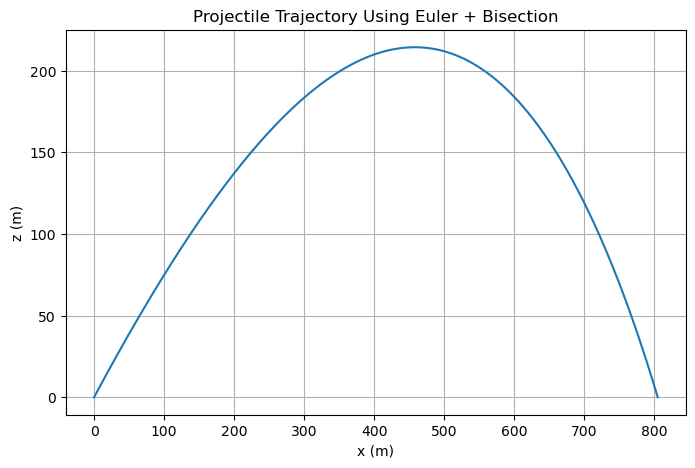

In [5]:
# Part A)
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Your Euler's method (unchanged)
# --------------------------------------------------------
def euler(f, x0, t0, tmax, dt):
    N = int(np.floor((tmax - t0) / dt) + 1)
    t = np.linspace(t0, tmax, N)
    x = np.zeros_like(t, dtype=float)
    x[0] = x0

    for n in range(len(t) - 1):
        x[n + 1] = x[n] + dt * f(t[n], x[n])
    return t, x


# --------------------------------------------------------
# Vector Euler Method (same logic as your scalar Euler)
# --------------------------------------------------------
def euler_vec(F, y0, t0, tmax, dt):
    N = int(np.floor((tmax - t0) / dt) + 1)
    t = np.linspace(t0, tmax, N)
    y = np.zeros((N, len(y0)))
    y[0] = y0

    for n in range(N - 1):
        y[n+1] = y[n] + dt * F(t[n], y[n])

        # Stop when projectile hits ground
        if y[n+1, 1] < 0:
            return t[:n+2], y[:n+2]

    return t, y


# --------------------------------------------------------
# Projectile ODE system with drag
# --------------------------------------------------------
g = 9.81
c = 1e-3  # drag coefficient

def projectile_ode(t, y):
    x, z, vx, vz = y
    v = np.sqrt(vx**2 + vz**2)
    return np.array([
        vx,
        vz,
        -c * vx * v,
        -g - c * vz * v
    ])


# --------------------------------------------------------
# Compute range for given v0 and theta0
# --------------------------------------------------------
def compute_range(v0, theta0_deg):
    theta = np.radians(theta0_deg)
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)

    y0 = np.array([0, 0, vx0, vz0])
    t, Y = euler_vec(projectile_ode, y0, 0, 60, 0.001)

    x = Y[:, 0]
    return x[-1]


# --------------------------------------------------------
# Bisection Method
# --------------------------------------------------------
def bisection(func, a, b, tol=1e-3, max_iter=100):
    fa = func(a)
    fb = func(b)

    if fa * fb > 0:
        raise ValueError("Bisection error: f(a) and f(b) must have opposite signs.")

    for _ in range(max_iter):
        m = 0.5 * (a + b)
        fm = func(m)

        if abs(fm) < tol:
            return m

        if fa * fm < 0:
            b = m
            fb = fm
        else:
            a = m
            fa = fm

    return 0.5 * (a + b)


# --------------------------------------------------------
# Set Target Distance
# --------------------------------------------------------
Target_Range_Miles = 0.5
target_range = Target_Range_Miles * 1609.34  # convert to meters
print("----------------------------------------------------")
print("Target Range (m):", target_range)


# ========================================================
# Solve for v0 first (holding theta fixed)
# ========================================================
fixed_theta = 40  # degrees

def f_v0(v0):
    return compute_range(v0, fixed_theta) - target_range

# Automatically bracket v0
v0_vals = np.linspace(10, 400, 300)
f_vals = [f_v0(v) for v in v0_vals]

v0_a = None
v0_b = None
for i in range(len(v0_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        v0_a = v0_vals[i]
        v0_b = v0_vals[i+1]
        break

if v0_a is None:
    raise RuntimeError("Cannot bracket v0 — try increasing search range.")

v0_solution = bisection(f_v0, v0_a, v0_b)
print("----------------------------------------------------")
print("Estimated v0 (m/s):", v0_solution)


# ========================================================
# Solve for theta using found v0
# ========================================================
def f_theta(theta):
    return compute_range(v0_solution, theta) - target_range

# Automatically bracket theta
theta_vals = np.linspace(1, 89, 200)
f_vals = [f_theta(th) for th in theta_vals]

theta_a = None
theta_b = None
for i in range(len(theta_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        theta_a = theta_vals[i]
        theta_b = theta_vals[i+1]
        break

if theta_a is None:
    raise RuntimeError("Cannot bracket theta — unexpected.")

theta_solution = bisection(f_theta, theta_a, theta_b)
print("Estimated θ0 (degrees):", theta_solution)
print("----------------------------------------------------")


# ========================================================
# Final trajectory with solved v0 and theta
# ========================================================
theta = np.radians(theta_solution)
vx0 = v0_solution * np.cos(theta)
vz0 = v0_solution * np.sin(theta)

y0 = np.array([0, 0, vx0, vz0])
t, Y = euler_vec(projectile_ode, y0, 0, 60, 0.001)

x = Y[:, 0]
z = Y[:, 1]

print("Final simulated range (m):", x[-1])
print("Maximum height (m):", np.max(z))
print("Flight time (s):", t[-1])
print("----------------------------------------------------")


# --------------------------------------------------------
# Plot the final trajectory
# --------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(x, z)
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title("Projectile Trajectory Using Euler + Bisection")
plt.grid(True)
plt.show()

In [ ]:
# Part A) - Alternative Approach
import numpy as np
from scipy.integrate import solve_ivp

# Constants
g = 9.81
c = 1e-3   # drag coefficient (1/m)


def projectile_ode(t, y):
    x, z, vx, vz = y
    v = np.sqrt(vx**2 + vz**2)
    dvx = -c * vx * v
    dvz = -g - c * vz * v
    return [vx, vz, dvx, dvz]


def simulate_range(v0, theta, tmax=200):
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)

    y0 = [0, 0, vx0, vz0]

    # Stop when z hits the ground again
    def hit_ground(t, y):
        return y[1]
    hit_ground.terminal = True
    hit_ground.direction = -1

    sol = solve_ivp(projectile_ode, [0, tmax], y0, events=hit_ground, max_step=0.05)

    if sol.status == 1:
        return sol.y_events[0][0][0]   # x-position at z = 0
    else:
        return np.nan


def Bisection_Method(target_x, theta, vmin=5, vmax=500):
    for _ in range(60):
        vmid = 0.5 * (vmin + vmax)
        x_mid = simulate_range(vmid, theta)

        if np.isnan(x_mid):
            vmin = vmid
            continue

        if x_mid < target_x:
            vmin = vmid
        else:
            vmax = vmid

    return 0.5 * (vmin + vmax)


def PartA(target_x, angles=np.linspace(0.2, 1.0, 20)):
    best = None

    for theta in angles:
        v0 = find_v0_for_range(target_x, theta)
        if best is None or v0 < best[1]:
            best = (theta, v0)

    return best

# Initial Guess 0.5 miles ≈ 804.67 m
miles = 0.5
meters = miles * 1609.34

target_range = meters # meters
theta_final, v0_final = PartA(target_range)

print("Best angle (deg):", np.degrees(theta_final))
print("Required v0 (m/s):", v0_final)

Best angle (deg): 40.40860239343701
Required v0 (m/s): 128.3661140525724


---

----------- VALIDATION RESULTS -----------
Target Range:            804.67 m
-------------------------------------------
θ = 38.7° → Range = 804.61 m  → Error = -0.06 m
θ = 40.4° → Range = 804.38 m → Error = -0.29 m
-------------------------------------------


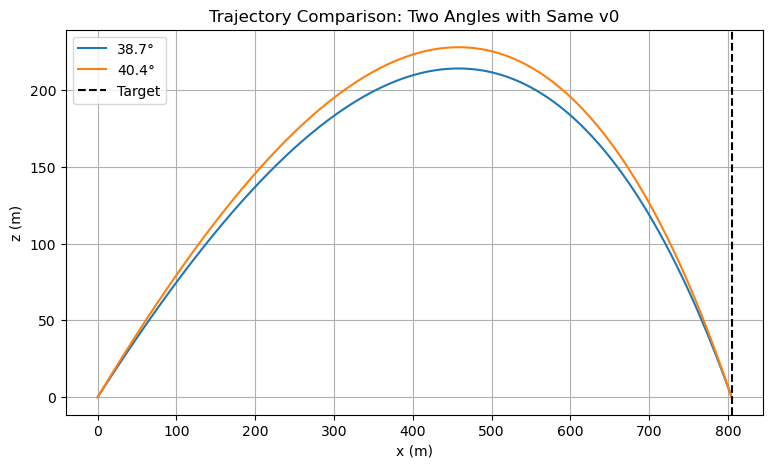

----------- CONCLUSION -----------
Both angles provide valid solutions for the given v0.


In [ ]:
# Validation
import numpy as np
import matplotlib.pyplot as plt
# ===============================================================
# VALIDATION SCRIPT FOR COMPARING TWO ANGLES WITH SAME v0
# ===============================================================

# Your known solutions:
v0_test = 128.32
theta_low = 38.7   # from your code
theta_high = 40.4  # from your alternative code
Target_Range_Miles = 0.5
target_range = Target_Range_Miles * 1609.34  # convert to meters

# ---------------------------------------------------------------
# Validate each angle by computing their true range
# ---------------------------------------------------------------
range_low = compute_range(v0_test, theta_low)
range_high = compute_range(v0_test, theta_high)

print("----------- VALIDATION RESULTS -----------")
print(f"Target Range:            {target_range:.2f} m")
print("-------------------------------------------")
print(f"θ = {theta_low}° → Range = {range_low:.2f} m  → Error = {range_low - target_range:.2f} m")
print(f"θ = {theta_high}° → Range = {range_high:.2f} m → Error = {range_high - target_range:.2f} m")
print("-------------------------------------------")

# ---------------------------------------------------------------
# Plot both trajectories on the same figure for visual verification
# ---------------------------------------------------------------
def compute_trajectory(v0, theta_deg):
    theta = np.radians(theta_deg)
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)
    y0 = np.array([0, 0, vx0, vz0])
    return euler_vec(projectile_ode, y0, 0, 60, 0.001)


# Compute both trajectories
t1, Y1 = compute_trajectory(v0_test, theta_low)
t2, Y2 = compute_trajectory(v0_test, theta_high)

x1, z1 = Y1[:,0], Y1[:,1]
x2, z2 = Y2[:,0], Y2[:,1]

plt.figure(figsize=(9,5))
plt.plot(x1, z1, label=f"{theta_low}°")
plt.plot(x2, z2, label=f"{theta_high}°")

plt.axvline(target_range, color='k', linestyle='--', label="Target")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title("Trajectory Comparison: Two Angles with Same v0")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
# Determine if both angles correctly hit the target
# ---------------------------------------------------------------
def hits_target(calc_range, target, tol=3.0):
    return abs(calc_range - target) <= tol

print("----------- CONCLUSION -----------")
if hits_target(range_low, target_range) and hits_target(range_high, target_range):
    print("Both angles provide valid solutions for the given v0.")
elif hits_target(range_low, target_range):
    print("Only the lower angle is valid.")
elif hits_target(range_high, target_range):
    print("Only the higher angle is valid.")
else:
    print("Neither angle reaches the target within the tolerance.")

Discusion

---

In [ ]:
# C) 😦